## Deconvolving single-cell family size distribution into chimeric and real components

In [1083]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM
from fsd import FSDModelGPLVM, FSDModelGPLVMRestricted
from dtm import DropletTimeMachineModel, PosteriorGeneExpressionSampler
from expr import FeatureBasedGeneExpressionModel, FeatureBasedGeneExpressionModelTrainer
from chimera import UniformChimeraRateModel, GeneLevelChimeraRateModel
from hvg import HighlyVariableGenesSelector

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, TraceMeanField_ELBO, SVI
from pyro.optim import Adam, ExponentialLR
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import NegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter
from typing import Tuple, Set, List, Dict, Callable

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [1084]:
device = torch.device('cuda')
dtype = torch.float

# dataset_name = 'hgmm_1k_v1'
# sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_v1_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = 'hgmm_1k_v2'
# sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_v2_only_expressing_sc_fingerprint.pkl'
# n_gene_groups = 100



# dataset_name = 'heart_1k_v2'
# sc_fingerprint_path = '/home/jupyter/data/10x/heart_1k_v2_only_expressing_sc_fingerprint.pkl'
# n_gene_groups = 100




dataset_name = 'pbmc4k_ss_rate_0.25'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_only_expressing_sc_fingerprint.pkl'
n_gene_groups = 100

# dataset_name = 'pbmc4k_ss_rate_0.25_small_new'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_small_new_sc_fingerprint.pkl'
# n_gene_groups = 10




# dataset_name = 'pbmc4k_merged_ss_rate_0.25_small_new'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_merged_ss_rate_0.25_small_new_sc_fingerprint.pkl'
# n_gene_groups = 10

# dataset_name = 'pbmc4k_merged_ss_rate_0.25'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_merged_ss_rate_0.25_sc_fingerprint.pkl'
# n_gene_groups = 100




# dataset_name = 'pbmc4k'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_only_expressing_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = 'pbmc4k_small_new'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_small_new_sc_fingerprint.pkl'
# n_gene_groups = 10




# dataset_name = 'pbmc4k_cr3'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_cr3_sc_fingerprint.pkl'
# n_gene_groups = 100




# dataset_name = 'pbmc4k_merged'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_merged_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = 'pbmc4k_merged_small_new'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_merged_small_new_sc_fingerprint.pkl'
# n_gene_groups = 10





# dataset_name = '5k_pbmc_v3'
# sc_fingerprint_path = '/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = '5k_pbmc_v3_small'
# sc_fingerprint_path = '/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_small_sc_fingerprint.pkl'
# n_gene_groups = 10

# dataset_name = '5k_pbmc_v3_ss_rate_0.5'
# sc_fingerprint_path = '/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_ss_rate_0.5_sc_fingerprint.pkl'
# n_gene_groups = 100

# dataset_name = '5k_pbmc_v3_ss_rate_0.5_small'
# sc_fingerprint_path = '/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_ss_rate_0.5_small_sc_fingerprint.pkl'
# n_gene_groups = 10




# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)

# sc_fingerprint_base = sc_fingerprint_base.filter_genes(
#     max_good_turing=1.,
#     min_total_gene_expression=1.).sort_genes_by_expression()
# gene_expr_ladder_idx_list = sc_fingerprint_base.gene_idx_list[::10]
# sc_fingerprint_base = sc_fingerprint_base.subset_genes(gene_expr_ladder_idx_list)

# # Filter unexpressed genes
# sc_fingerprint_base = sc_fingerprint_base.filter_genes(
#     max_good_turing=1.,
#     min_total_gene_expression=1.).sort_genes_by_expression()

# Instantiate the fingerprint datastore
sc_fingerprint_dtm = SingleCellFingerprintDTM(
    sc_fingerprint_base,
    n_gene_groups=n_gene_groups,
    n_cell_pca_features=10,
    allow_dense_int_ndarray=False,
    low_family_size_cdf_threshold=0.0,
    device=device,
    dtype=dtype)

In [1085]:
# chunk_size = 20
# stride = 200
# n_chunks = int(sc_fingerprint_base.n_genes / stride)
# gene_idx_list = []
# for i in range(n_chunks):
#     gene_idx_list += [sc_fingerprint_base.gene_idx_list[i * stride + j] for j in range(chunk_size)]

# sc_fingerprint_base_new = sc_fingerprint_base.subset_genes(gene_idx_list)
# sc_fingerprint_base_new.save('/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_ss_rate_0.5_small_sc_fingerprint.pkl')

In [1086]:
# sc_fingerprint_base_new = sc_fingerprint_base.subset_genes(gene_idx_list)
# sc_fingerprint_base_new.save('/home/jupyter/data/10x/5k_pbmc_protein_v3_nextgem_small_sc_fingerprint.pkl')

In [1087]:
init_params_dict = {
    'hvg.n_selected_genes': 1000, ## NOTE must set to a fraction of total genes 
    'hvg.neglect_expr_bottom_fraction': 0.25,
    'hvg.neglect_expr_top_fraction': 0.0,
    'hvg.gene_group_prefixes': None,
#     'hvg.gene_group_prefixes': ['mm10', 'hg19'],
    
    'hvg.expr.vsgp.n_inducing_points': 50,
    'hvg.expr.vsgp.init_rbf_kernel_variance': 0.5,
    'hvg.expr.vsgp.init_rbf_kernel_lengthscale': 0.5,
    'hvg.expr.vsgp.init_whitenoise_kernel_variance': 0.5,
    'hvg.expr.vsgp.init_posterior_scale': 0.5,
    'hvg.expr.vsgp.init_mean_intercept': np.asarray([0.0, 1.0, 0.0]),
    'hvg.expr.vsgp.init_mean_slope': np.asarray([1.0, 0.0, -1.0]),
    'hvg.expr.vsgp.cholesky_jitter': 1e-3,
    'hvg.expr.vsgp.min_noise': 1e-3,
    
    'hvg.expr.trainer.adam_lr': 1e-2,
    'hvg.expr.trainer.adam_betas': (0.9, 0.99),
    'hvg.expr.trainer.n_training_iterations': 2000,
    'hvg.expr.trainer.training_log_frequency': 50,
    'hvg.expr.trainer.minibatch.genes_per_gene_group': 10,
    'hvg.expr.trainer.minibatch.expressing_cells_per_gene': 10,
    'hvg.expr.trainer.minibatch.silent_cells_per_gene': 10,
    'hvg.expr.trainer.minibatch.sampling_strategy': 'without_replacement',

    'chimera.alpha_c_prior_loc': 1e-4,
    'chimera.alpha_c_prior_scale': 1e-4,
    'chimera.beta_c_prior_loc': 1.0,
    'chimera.beta_c_prior_scale': 2e-1,
    
    'fsd.enable_fsd_w_dirichlet_reg': True,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.01,
    'fsd.w_hi_dirichlet_concentration': 0.01,
        
    'fsd.init_min_mu_lo': 0.001,
    'fsd.init_min_mu_hi': 0.1,
    'fsd.init_max_phi_lo': 1.0,
    'fsd.init_max_phi_hi': 0.5,
    'fsd.init_mu_decay': 0.9,
    'fsd.init_w_decay': 0.8,
    'fsd.init_mu_lo_to_mu_hi_ratio': 0.1,
    
    'model.n_particles_fingerprint_log_like': 20,
    
    'expr.init_posterior_scale': 0.2,
    
    'fsd.gplvm.n_inducing_points': 5,
    'fsd.gplvm.latent_dim': 2,
    'fsd.gplvm.init_rbf_kernel_variance': 0.2,
    'fsd.gplvm.init_rbf_kernel_lengthscale': 0.2,
    'fsd.gplvm.init_whitenoise_kernel_variance': 0.2,
    'fsd.gplvm.cholesky_jitter': 1e-3,
    'fsd.gplvm.min_noise': 0.01,
    
    'fsd.init_fsd_xi_posterior_scale': 0.2,
    'fsd.xi_posterior_min_scale': 0.01,
}


loss_scale = np.sum(sc_fingerprint_dtm.total_obs_molecules_per_cell) / 100
default_constraint_strength = loss_scale
medium_constraint_strength = 1e2 * loss_scale
strong_constraint_strength = 1e4 * loss_scale

model_constraint_params_dict = {
#     # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
#     'phi_fsd_lo_comps_nj': {
#         'pin_value': 1.0,
#         'pin_strength': default_constraint_strength,
#         'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_fsd_hi_comps_nj': {
        'upper_bound_value': 0.7,
        'upper_bound_width': 0.2,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2},

    # no component of p_hi is allowed to be too over-dispersed
    'phi_fsd_lo_comps_nj': {
        'upper_bound_value': 1.2,
        'upper_bound_width': 0.2,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2},

    # no component of p_lo can have too small or too large of a mean family size
    # compared to the empirical mean
    'mu_fsd_lo_comps_to_mu_empirical_ratio_nj': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.01,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 0.5,
        'upper_bound_width': 0.1,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size
    # compared to the empirical mean
    'mu_fsd_hi_comps_to_mu_empirical_ratio_nj': {
        'lower_bound_value': 0.2,
        'lower_bound_width': 0.1,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
#     # the ratio of observed chimeric to real molecules can not exceed a certain value
#     'p_obs_lo_to_p_obs_hi_ratio_n': {
#         'upper_bound_value': 0.2,
#         'upper_bound_width': 0.05,
#         'upper_bound_strength': default_constraint_strength,
#         'upper_bound_exponent': 2},

    # possibly the most important hyperparameter!
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'mu_fsd_lo_to_mu_fsd_hi_ratio_n': {
        'upper_bound_value': 0.10,
        'upper_bound_width': 0.05,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2,
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2},
    
    # possibly the most important hyperparameter!
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'e_lo_obs_prior_fraction_n': {
        'upper_bound_value': 0.2,  # very important
        'upper_bound_width': 0.05,
        'upper_bound_strength': medium_constraint_strength,
        'upper_bound_exponent': 2,
        'lower_bound_value': 0.01,  # very important
        'lower_bound_width': 0.01,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},

    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_hi_comps_nj': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.005,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_lo_comps_nj': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.005,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},

    # make sure that log_mu_e_hi is not too small or too large (to prevent over/under-flows)
    'log_mu_e_hi_n': {
        'lower_bound_value': -10.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 10.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},

    # make sure that log_phi_e_hi is not too small or too large (to prevent over/under-flows)
    'log_phi_e_hi_n': {
        'lower_bound_value': -5.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2}
}

slow_params = {
    
}

weight_decay_params = {
    
}

slow_modules = {

}

In [1088]:
root = '/home/jupyter/data/10x/out'
#suffix = "all_genes__fsd_gplvm__no_dirichlet__rc_15"
suffix = "all_genes__11__final"

output_path = os.path.join(
    root,
    f"{dataset_name}_" +
    f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__all_genes__11__final
/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__all_genes__11__final/checkpoints


## Human Mouse Mixture

In [1089]:
# mouse_gene_indices = [
#     j for j in range(sc_fingerprint_base.n_genes)
#     if sc_fingerprint_base.gene_names_list[j].find('mm10') == 0]
# human_gene_indices = [
#     j for j in range(sc_fingerprint_base.n_genes)
#     if sc_fingerprint_base.gene_names_list[j].find('hg19') == 0]

# total_mouse_umi = np.asarray(np.sum(sc_fingerprint_dtm.sparse_count_matrix_csc[:, mouse_gene_indices], -1)).flatten()
# total_human_umi = np.asarray(np.sum(sc_fingerprint_dtm.sparse_count_matrix_csc[:, human_gene_indices], -1)).flatten()

# plt.scatter(total_mouse_umi, total_human_umi)
# plt.xscale('log')
# plt.yscale('log')

# mouse_droplets = np.where((total_mouse_umi > 1000) & (total_human_umi < 1000))[0]
# human_droplets = np.where((total_human_umi > 1000) & (total_mouse_umi < 1000))[0]
# doublets = np.where((total_mouse_umi > 1000) & (total_human_umi > 1000))[0]

## Highly Variable Genes (for cell feature selection)

In [1090]:
pyro.clear_param_store()

hvg_selector = HighlyVariableGenesSelector(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    init_params_dict=init_params_dict,
    device=device,
    dtype=dtype)

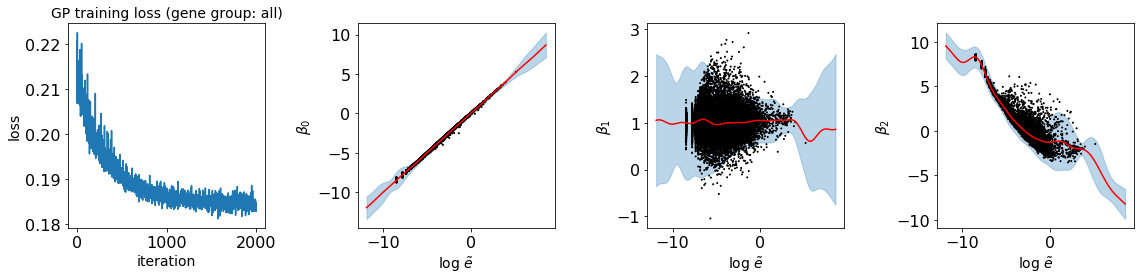

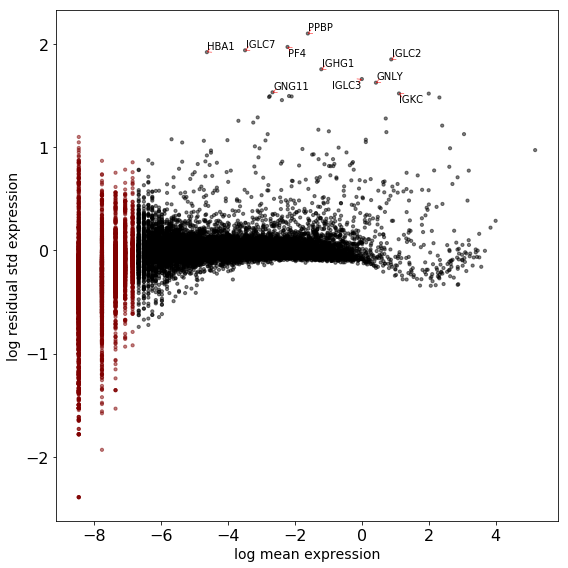

In [1091]:
hvg_selector.plot_diagnostics(plt)

In [1094]:
sc_fingerprint_dtm.set_highly_variable_gene_indices(hvg_selector.highly_variable_gene_indices)

AssertionError: Highly variable genes are already specified!

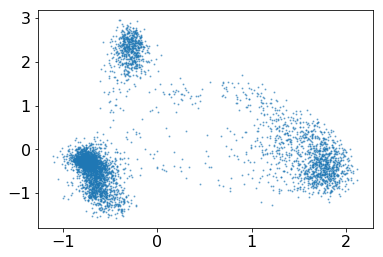

In [1095]:
# fp = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(3)
# mean_fs = np.sum(fp * np.arange(1, 54)[None, :], -1) / (1e-8 + np.sum(fp, -1))

# ind_lo = np.where(mean_fs <= 5)[0]
# ind_hi = np.where(mean_fs > 10)[0]
# plt.plot(np.sum(fp, 0))

plt.figure()
plt.scatter(sc_fingerprint_dtm.features_per_cell[:, 1],
            sc_fingerprint_dtm.features_per_cell[:, 2], s=1 ,alpha=0.5)

# plt.scatter(sc_fingerprint_dtm.features_per_cell[ind_lo, 1],
#             sc_fingerprint_dtm.features_per_cell[ind_lo, 2], s=5 ,alpha=0.5, color='red')

# plt.hist(sc_fingerprint_dtm.total_obs_molecules_per_cell[ind_lo], bins=50, alpha=0.5, log=True, range=(0, 50000));
# plt.hist(sc_fingerprint_dtm.total_obs_molecules_per_cell[ind_hi], bins=50, alpha=0.5, log=True, range=(0, 50000));

## Pretraining the feature-based gene expression prior

In [1045]:
# np.save('pbmc4k_hvg.npy', hvg_selector.highly_variable_gene_indices)

In [1046]:
# np.save('hgmm_1k_v1_hvg.npy', hvg_selector.highly_variable_gene_indices)

In [1047]:
# np.save('hgmm_1k_hvg.npy', hvg_selector.highly_variable_gene_indices)

In [1048]:
# np.save('pbmc4k_small_new_hvg.npy', hvg_selector.highly_variable_gene_indices)

In [1049]:
# sc_fingerprint_dtm.set_highly_variable_gene_indices(np.load('pbmc4k_small_new_hvg.npy'))

In [1050]:
# sc_fingerprint_dtm.set_highly_variable_gene_indices(np.load('hgmm_1k_hvg.npy'))

In [1096]:
pyro.clear_param_store()

feature_based_gene_expression_model = FeatureBasedGeneExpressionModel(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    init_features_ard_scale=10.0,
    phi_scale=1e-2,
    activation=torch.nn.Softplus(),
    enable_phi_prior=False,
    hidden_dims=[],
    device=device,
    dtype=dtype)

In [1097]:
feature_based_gene_expression_model_trainer = FeatureBasedGeneExpressionModelTrainer(
    feature_based_gene_expression_model=feature_based_gene_expression_model,
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    adam_lr=1e-2,
    adam_betas=(0.9, 0.99))

In [1098]:
feature_based_gene_expression_model_trainer.run_training(
    n_training_iterations=2000,
    training_log_frequency=100,
    minibatch_genes_per_gene_group=10,
    minibatch_expressing_cells_per_gene=50,
    minibatch_silent_cells_per_gene=50,
    minibatch_sampling_strategy='without_replacement')

In [1054]:
# _ = plt.hist(feature_based_gene_expression_model.log_alpha_posterior_loc_g.exp().reciprocal().detach().cpu().numpy(), bins=100, log=True)

In [1102]:
# gene_index = 6
# mb_data = sc_fingerprint_dtm.generate_single_gene_counts_minibatch_data(
#     gene_index=gene_index,
#     cell_index_list=np.arange(sc_fingerprint_dtm.n_cells),
#     count_matrix_type='raw',
#     n_particles_cell=1)

# print(sc_fingerprint_base.gene_names_list[gene_index])
# print((-feature_based_gene_expression_model.log_alpha_posterior_loc_g[gene_index]).exp().item())

# with torch.no_grad():
#     out = feature_based_gene_expression_model.decode_output_to_nb_params_dict(
#         feature_based_gene_expression_model.guide(mb_data), mb_data)
#     mu = out['log_mu_e_hi_n'].exp()
    
# x = mb_data['counts_tensor'].cpu().numpy()
# # x = np.asarray(sc_fingerprint_dtm.sparse_count_matrix_csc[:, gene_index].todense()).flatten()
# y = mu.cpu().numpy()

# plt.figure()
# plt.scatter(x, y, s=1)
# plt.gca().set_aspect('equal')

# plt.figure()
# plt.scatter(np.log(sc_fingerprint_dtm.arithmetic_mean_obs_expr_per_gene),
#             feature_based_gene_expression_model.gamma_posterior_loc_gf[:, 0].detach().cpu().numpy(), s=1, alpha=0.5)

## Training the Droplet Time Machine (TM)

In [1148]:
n_training_iters = 20_000

minibatch_genes_per_gene_group = 10
minibatch_expressing_cells_per_gene = 50
minibatch_silent_cells_per_gene = 5
minibatch_sampling_strategy = 'without_replacement'

slow_params_lr_reduction_factor = 1.0
slow_modules_lr_reduction_factor = 1.0
weight_decay = 0.0
adam_lr_start = 1e-2
adam_lr_stop = 1e-3
adam_betas = (0.9, 0.99)
adam_eps = 1e-6

In [1149]:
pyro.clear_param_store()

gene_expression_model = feature_based_gene_expression_model

fsd_model = FSDModelGPLVM(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=1,
    init_params_dict=init_params_dict,
    device=device,
    dtype=dtype)

# fsd_model = FSDModelGPLVMRestricted(
#     sc_fingerprint_dtm=sc_fingerprint_dtm,
#     n_fsd_hi_comps=2,
#     init_params_dict=init_params_dict,
#     device=device,
#     dtype=dtype)

chimera_rate_model = UniformChimeraRateModel(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    init_params_dict=init_params_dict,
    device=device,
    dtype=dtype)

# chimera_rate_model = GeneLevelChimeraRateModel(
#     sc_fingerprint_dtm=sc_fingerprint_dtm,
#     init_params_dict=init_params_dict,
#     trainable_prior=True,
#     device=device,
#     dtype=dtype)

dtm = DropletTimeMachineModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    gene_expression_model=gene_expression_model,
    chimera_rate_model=chimera_rate_model,
    fsd_model=fsd_model,
    monitor_constraint_pressure=True,
    device=device,
    dtype=dtype)

def get_adam_args(
    base_lr: float,
    slow_params_base_lr: float,
    slow_modules_base_lr: float,
    slow_params: Set[str],
    slow_modules: Set[str],
    weight_decay_params: Set[str],
    weight_decay: float,
    adam_eps: float,
    adam_betas: Tuple[float, float]) -> Callable:
    
    def adam_args(module_name, param_name):
        if module_name in slow_modules:
            lr = slow_modules_base_lr
        elif param_name in slow_params:
            lr = slow_params_base_lr
        else:
            lr = base_lr
            
        if param_name in weight_decay_params:
            weight_decay = weight_decay
        else:
            weight_decay = 0
            
        return {
            'lr': lr,
            'eps': adam_eps,
            'betas': adam_betas,
            'weight_decay': weight_decay,
        }

    return adam_args

adam_args = get_adam_args(
    base_lr=adam_lr_start,
    slow_params_base_lr=slow_params_lr_reduction_factor * adam_lr_start,
    slow_modules_base_lr=slow_modules_lr_reduction_factor * adam_lr_start,
    slow_params=slow_params,
    slow_modules=slow_modules,
    weight_decay_params=weight_decay_params,
    weight_decay=weight_decay,
    adam_eps=adam_eps,
    adam_betas=adam_betas)

optimizer = torch.optim.Adam
adam_lr_decay_per_iter = np.exp(np.log(adam_lr_stop / adam_lr_start) / n_training_iters)

scheduler = pyro.optim.ExponentialLR({
    'optimizer': optimizer,
    'optim_args': adam_args,
    'gamma': adam_lr_decay_per_iter})

svi = SVI(
    model=dtm.model,
    guide=dtm.guide,
    optim=scheduler,
    loss=Trace_ELBO())

In [1150]:
i_iter = 0
loss_hist = []
# load_latest_checkpoint(checkpoint_path)

In [1151]:
# model_output_path = os.path.join(
#     output_path,
#     f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
# pyro.get_param_store().load(model_output_path)

In [1182]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / np.sum(sc_fingerprint_dtm.total_obs_molecules_per_cell)

t0 = time.time()

while i_iter < n_training_iters:
    
    # generate stratified minibatch
    mb_data = sc_fingerprint_dtm.generate_fingerprint_stratified_sample(
        minibatch_genes_per_gene_group,
        minibatch_expressing_cells_per_gene,
        minibatch_silent_cells_per_gene,
        minibatch_sampling_strategy)

    # SVI update
    mb_loss = svi.step(mb_data)
    scheduler.step(epoch=i_iter)
    i_iter += 1
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    loss_hist.append(mb_loss_per_cell_gene)
    
    if i_iter % print_loss_frequency == 0 and i_iter > 0:

        # calculate loss stats
        t1 = time.time()
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        
        logging.warning(
            f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, '
            f'time: {(t1 - t0):.3f}s')
        
        # reset
        mb_loss_list = []
        fsd_abs_res_list = []
        t0 = t1

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

In [1183]:
dtm.constraint_pressure_dict

{'phi_fsd_hi_comps_nj': {'upper_bound_pressure': 8219669.761197912},
 'phi_fsd_lo_comps_nj': {'upper_bound_pressure': 5206150.224296171},
 'mu_fsd_lo_comps_to_mu_empirical_ratio_nj': {'lower_bound_pressure': 10957.274498686707,
  'upper_bound_pressure': 0.0},
 'mu_fsd_hi_comps_to_mu_empirical_ratio_nj': {'lower_bound_pressure': 3.800220285734629e-41,
  'upper_bound_pressure': 0.0},
 'mu_fsd_lo_to_mu_fsd_hi_ratio_n': {'lower_bound_pressure': 0.0,
  'upper_bound_pressure': 31983.3658003546},
 'e_lo_obs_prior_fraction_n': {'lower_bound_pressure': 4282.804342305904,
  'upper_bound_pressure': 732.0041069920214},
 'w_fsd_hi_comps_nj': {'lower_bound_pressure': 0.0},
 'w_fsd_lo_comps_nj': {'lower_bound_pressure': 0.0},
 'log_mu_e_hi_n': {'lower_bound_pressure': 29903.671527547143,
  'upper_bound_pressure': 2.28017222828012e-20},
 'log_phi_e_hi_n': {'lower_bound_pressure': 202.2712400754386,
  'upper_bound_pressure': 0.0}}

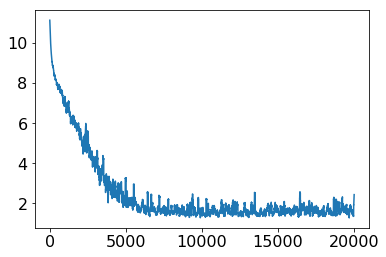

In [1184]:
smoothing = True
log = True
window_length = 51
polyorder = 1

if smoothing and len(loss_hist) > window_length:
    smooth_loss_hist = savgol_filter(
        loss_hist,
        window_length=window_length,
        polyorder=polyorder)
else:
    smooth_loss_hist = loss_hist
if log:
    smooth_loss_hist = np.log1p(smooth_loss_hist)

ax = plt.gca()
ax.plot(smooth_loss_hist)

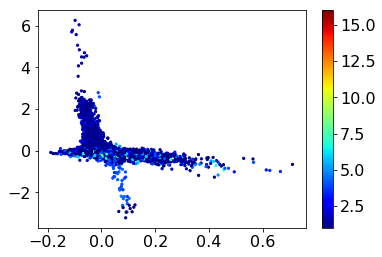

In [1185]:
fsd_Xu = fsd_model.gplvm.Xu.detach().cpu().numpy()
fsd_latent_posterior_loc_gl = fsd_model.fsd_latent_posterior_loc_gl.detach().cpu().numpy()

plt.scatter(fsd_latent_posterior_loc_gl[:, 0], fsd_latent_posterior_loc_gl[:, 1],
            s=5, c=sc_fingerprint_dtm.empirical_fsd_mu_hi, cmap=plt.cm.jet)
plt.colorbar()

# plt.scatter(fsd_Xu[:, 0], fsd_Xu[:, 1])
# plt.xlim((-1, 1))
# plt.ylim((-1, 1))

In [1186]:
# plt.hist(chimera_rate_model.log_beta_c_posterior_loc_g.exp().detach().cpu().numpy(), bins=50, log=True);
# print(chimera_rate_model.log_alpha_c_posterior_loc_g.exp().mean().item())
# print(chimera_rate_model.log_alpha_c_posterior_loc_g.exp().std().item())
# print(chimera_rate_model.log_beta_c_posterior_loc_g.exp().mean().item())
# print(chimera_rate_model.log_beta_c_posterior_loc_g.exp().std().item())

In [1187]:
print(chimera_rate_model.alpha_c_posterior_loc.item())
print(chimera_rate_model.beta_c_posterior_loc.item())

6.007238698657602e-05
0.5317646265029907


## Exploration

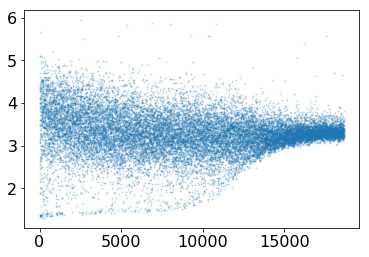

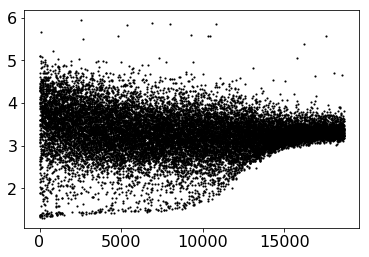

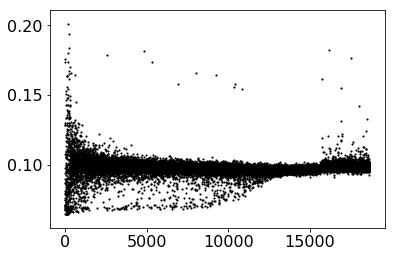

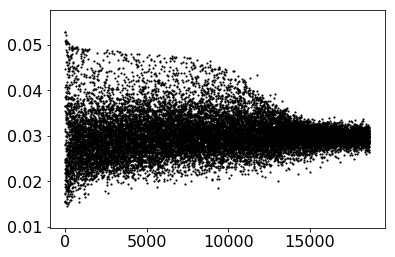

In [1188]:
with torch.no_grad():
    fsd_params_dict = fsd_model.decode(fsd_model.get_sorted_fsd_xi(fsd_model.fsd_xi_posterior_loc_gq))
    empirical_mu = torch.tensor(sc_fingerprint_dtm.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1)
    mu_hi = fsd_params_dict['mu_hi'].cpu().numpy()
    w_hi = fsd_params_dict['w_hi'].cpu().numpy()
    phi_hi = fsd_params_dict['phi_hi'].cpu().numpy()
    mu_lo = fsd_params_dict['mu_lo'].cpu().numpy()
    w_lo = fsd_params_dict['w_lo'].cpu().numpy()
    x = np.arange(sc_fingerprint_dtm.n_genes)
    
# rgba_colors_1 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
# rgba_colors_1[:, 0] = 1.0
# rgba_colors_1[:, 3] = w_hi[:, 0]

# rgba_colors_2 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
# rgba_colors_2[:, 1] = 1.0
# rgba_colors_2[:, 3] = w_hi[:, 1]

mu_lo_mean = np.sum(mu_lo * w_lo, -1)
mu_hi_mean = np.sum(mu_hi * w_hi, -1)

plt.figure()
for i in range(fsd_model.n_fsd_hi_comps):
    plt.scatter(x, mu_hi[:, i], marker='.', s=5, alpha=0.2)


plt.figure()
plt.scatter(x, mu_hi_mean, marker='.', s=5, color='black')

plt.figure()
plt.scatter(x, mu_lo_mean, marker='.', s=5, color='black')

plt.figure()
plt.scatter(x, mu_lo_mean/mu_hi_mean, marker='.', s=5, color='black')

#     plt.scatter(x, mu_hi[:, 2], marker='.', s=5, color=rgba_colors_3)
    # plt.ylim([0, 5])

LYZ
mean_e_obs: 11.059197963080841
mean_e_hi (map): 12.40971780182474
e_hi_z: 3374
e_obs_z: 2849
mu_e_hi (prior): 14.76811408996582
phi_e_hi (prior): 0.3727043867111206
mean_e_hi (prior): 14.76811408996582
mu_lo: [0.0644] += [0.0006]
phi_lo: [0.4745] += [0.1034]
w_lo: [1.] += [0.]
mu_hi: [2.7304] += [0.027]
phi_hi: [0.3365] += [0.0058]
w_hi: [1.] += [0.]
p_obs_hi: 0.856 +- 0.002
p_obs_lo: 0.061 +- 0.001


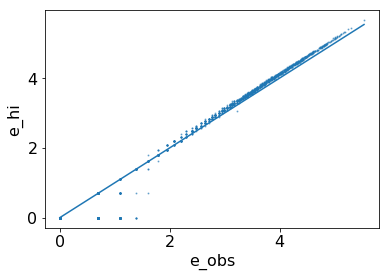

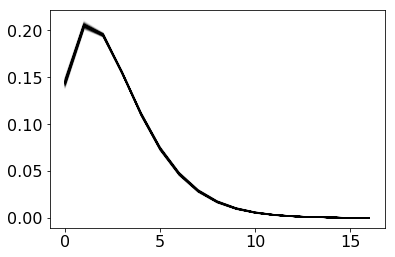

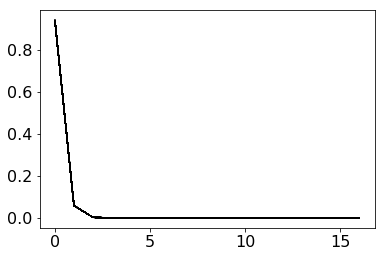

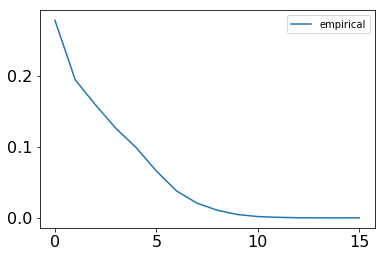

In [1189]:
# original_gene_index = 14724
# gene_index = sc_fingerprint_base.gene_idx_list.index(original_gene_index)
# print(original_gene_index)

gene_index = sc_fingerprint_base.gene_names_list.index('LYZ')
print(sc_fingerprint_base.gene_names_list[gene_index])

sampler = PosteriorGeneExpressionSampler(dtm, device, dtype)
expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
    gene_index=gene_index,
    n_proposals_omega=10,
    n_particles_omega=5,
    n_particles_cell=5,
    n_particles_expression=5,
    cell_shard_size=100,
    run_mode="full",
    only_expressing_cells=False)

# expr_dict =  sampler.get_gene_expression_posterior_moments_summary(
#     gene_index=gene_index,
#     n_particles_omega=100,
#     n_particles_cell=1,
#     cell_shard_size=1000,
#     only_expressing_cells=False,
#     run_mode='full',
#     mode_estimation_strategy='lower_bound')

e_hi = expr_dict['e_hi_map']

data = sc_fingerprint_dtm.generate_single_gene_fingerprint_minibatch_data(
    gene_index, np.arange(0, sc_fingerprint_dtm.n_cells), 1)
out = gene_expression_model.guide(data)
decoded = gene_expression_model.decode_output_to_nb_params_dict(out, data)
mu_e_hi_n = decoded['log_mu_e_hi_n'].exp()
phi_e_hi_n = decoded['log_phi_e_hi_n'].exp()

e_hi_prior_dist = NegativeBinomial(
    mu=mu_e_hi_n,
    phi=phi_e_hi_n)

e_obs = np.asarray(sc_fingerprint_dtm.sparse_count_matrix_csc[:, gene_index].todense()).squeeze(1)
mean_e_obs = np.mean(e_obs)
mean_e_hi = np.mean(e_hi)
e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
print('mean_e_hi (map):', mean_e_hi)
print('e_hi_z:', e_hi_z)
print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', mu_e_hi_n.mean().item())
print('phi_e_hi (prior):', phi_e_hi_n.mean().item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean.mean().item())


fig = plt.figure()
plt.scatter(np.log1p(e_obs), np.log1p(e_hi), s=1, alpha=0.5)
plt.plot(np.log1p([0, np.max(e_obs)]), np.log1p([0, np.max(e_obs)]))
plt.xlabel('e_obs', fontsize=16)
plt.ylabel('e_hi', fontsize=16)

n_posterior_samples = 500
cell_index_array = np.zeros((n_posterior_samples,), dtype=np.int).astype(np.int32)
gene_index_array = gene_index * np.ones_like(cell_index_array).astype(np.int32)
cell_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
gene_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
single_gene_mb_data = sc_fingerprint_dtm.generate_fingerprint_torch_minibatch_data(
    cell_index_array,
    gene_index_array,
    cell_sampling_site_scale_factor_array,
    gene_sampling_site_scale_factor_array,
    np.zeros((n_posterior_samples, sc_fingerprint_dtm.max_family_size), dtype=np.float32))
guide_trace = poutine.trace(dtm.guide).get_trace(single_gene_mb_data)
fsd_params_dict = guide_trace.nodes['_RETURN']['value']['fsd_guide_output_dict']

with torch.no_grad():
    np.set_printoptions(precision=4)
    for k, v in fsd_params_dict.items():
        m = torch.mean(v, 0).cpu().numpy()
        s = torch.std(v, 0).cpu().numpy()
        print(f'{k}: {m} += {s}')
        
dist_lo, dist_hi = fsd_model.get_fsd_components(fsd_params_dict)
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()

p_obs_hi_mean, p_obs_hi_std = np.mean(1 - p_hi[:, 0]), np.std(p_hi[:, 0])
p_obs_lo_mean, p_obs_lo_std = np.mean(1 - p_lo[:, 0]), np.std(p_lo[:, 0])
print(f"p_obs_hi: {p_obs_hi_mean:.3f} +- {p_obs_hi_std:.3f}")
print(f"p_obs_lo: {p_obs_lo_mean:.3f} +- {p_obs_lo_std:.3f}")

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_hi[i, :], alpha=0.01, color='black')

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_lo[i, :], alpha=0.01, color='black')


empircal_fsd = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index, None)
# empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
# plt.plot(model_fsd, label='model')
plt.legend()
# plt.yscale('log')

1.1221173400867197


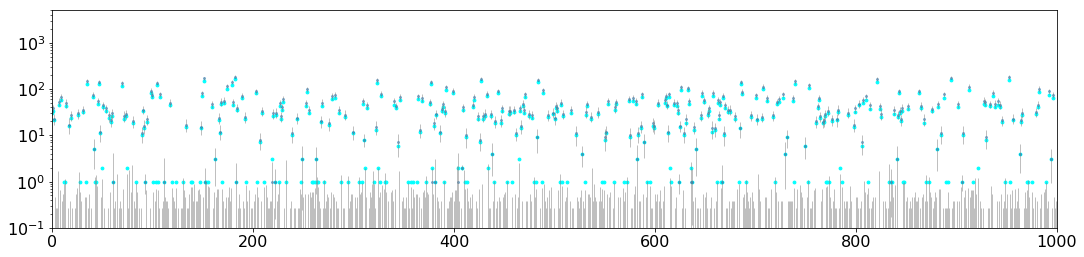

In [1190]:
plt.figure(figsize=(18,4))

err = 3 * expr_dict['e_hi_std']
plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), e_obs, marker='o', color='cyan', s=8)
plt.errorbar(np.arange(0, sc_fingerprint_dtm.n_cells),
             expr_dict['e_hi_map'],
             barsabove=True, elinewidth=1, lw=0,
             marker='.', ecolor='gray', markersize=4,
             yerr=err, alpha=0.5)
plt.ylim((0, 2.5 * np.max(expr_dict['e_hi_map'])))
# plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)
plt.xlim((0, 1000))
plt.ylim((1e-1, 5000))
plt.yscale('log')

print(np.sum(expr_dict['e_hi_map']) / np.sum(e_obs))

# print(np.sum(expr_dict['e_hi_map'][mouse_droplets]) / np.sum(e_obs[mouse_droplets]))
# print(np.sum(expr_dict['e_hi_map'][human_droplets]) / np.sum(e_obs[human_droplets]))

In [1072]:
fp = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index)

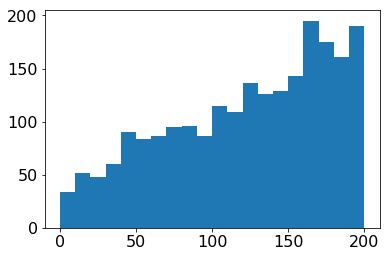

In [1073]:
plt.hist(fp.sum(-1), range=(0, 200), bins=20);

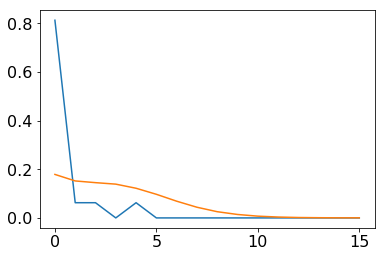

In [1022]:
plt.plot(fp[fp.sum(-1) <= 2, :].sum(0) / fp[fp.sum(-1) <= 2, :].sum(0).sum(0))
plt.plot(fp[fp.sum(-1) > 100, :].sum(0) / fp[fp.sum(-1) > 100, :].sum(0).sum(0))

In [728]:
np.where((expr_dict['e_hi_map'] > 0) & (e_obs == 0))

(array([], dtype=int64),)

In [729]:
sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index)[22, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

Text(0.5, 0, '$e_\\mathrm{obs}$')

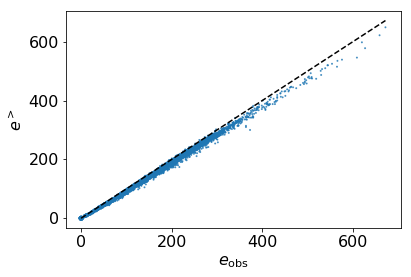

In [1023]:
from collections import Counter
x_vals = e_obs
y_vals = expr_dict['e_hi_map']
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
plt.ylabel(r'$e^>$', fontsize=16)
plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

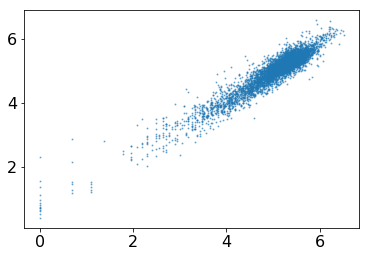

In [1024]:
plt.scatter(
    np.log1p(e_obs),
    np.log1p(e_hi_prior_dist.mean.detach().cpu().numpy()), s=1, alpha=0.5)

(0.1, 50)

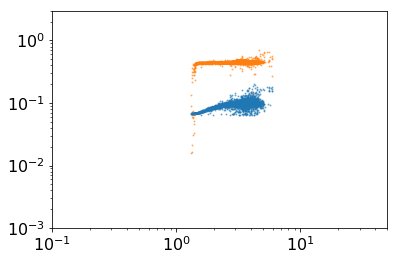

In [1191]:
with torch.no_grad():
    fsd_params_dict = fsd_model.decode(fsd_model.fsd_xi_posterior_loc_gq)
    dist_lo, dist_hi = fsd_model.get_fsd_components(fsd_params_dict)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
# assignments = torch.argmin(
#     (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")).unsqueeze(-1)
#      - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze(), s=1, alpha=0.5)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-3, 3.))
plt.xlim((0.1, 50)) 


In [733]:
# with torch.no_grad():
#     fsd_hi_params_dict = fsd_codec.decode_xi_to_fsd_hi_params_dict(pyro.param("fsd_xi_posterior_loc_gq"))
#     log_w_hi_nj = fsd_hi_params_dict['w_hi'].log()
#     log_mu_hi_nj = fsd_hi_params_dict['mu_hi'].log()
#     log_mu_hi_n = (log_w_hi_nj + log_mu_hi_nj).logsumexp(dim=-1)
#     fsd_codec.vsgp.set_data(X=log_mu_hi_n, y=None)
#     log_mu_lo_loc_rn, log_mu_lo_var_rn = fsd_codec.vsgp.model()
#     log_mu_lo_loc_n = log_mu_lo_loc_rn.squeeze(0).cpu().numpy()
#     log_mu_lo_scale_n = log_mu_lo_var_rn.squeeze(0).sqrt().cpu().numpy()
#     log_mu_hi_n = log_mu_hi_n.cpu().numpy()

# ax = plt.gca()
# ind = np.argsort(log_mu_hi_n)
# ax.plot(log_mu_hi_n[ind], log_mu_lo_loc_n[ind], color='red')
# ax.fill_between(log_mu_hi_n[ind],
#                 log_mu_lo_loc_n[ind] - 2.0 * log_mu_lo_scale_n[ind],
#                 log_mu_lo_loc_n[ind] + 2.0 * log_mu_lo_scale_n[ind],
#                 color='C0', alpha=0.3)
# ax.set_xlabel('$\log \,\, \\mu^>$', fontsize=14)
# ax.set_ylabel('$\log \,\, \\mu^<$', fontsize=14)

# # plt.scatter(mu_hi.squeeze(), mu_lo.squeeze(), s=1, alpha=0.1, c=assignments, cmap=plt.cm.jet)
# # plt.ylim((1e-3, 2.))
# # plt.xlim((0.1, 50)) 


In [ ]:
# ax = plt.gca()

# with torch.no_grad():
#     fsd_hi_params_dict = fsd_model.decode_xi_to_fsd_hi_params_dict(pyro.param("fsd_xi_posterior_loc_gq"))
#     log_w_hi_nj = fsd_hi_params_dict['w_hi'].log()
#     log_mu_hi_nj = fsd_hi_params_dict['mu_hi'].log()
#     log_mu_hi_n = (log_w_hi_nj + log_mu_hi_nj).logsumexp(dim=-1)
#     fsd_model.vsgp.set_data(X=log_mu_hi_n, y=None)
#     log_mu_lo_loc_rn, log_mu_lo_var_rn = fsd_model.vsgp.model()
#     log_mu_lo_loc_n = log_mu_lo_loc_rn.squeeze(0).cpu().numpy()
#     log_mu_lo_scale_n = log_mu_lo_var_rn.squeeze(0).sqrt().cpu().numpy()
#     log_mu_hi_n = log_mu_hi_n.cpu().numpy()

# ind = np.argsort(log_mu_hi_n)
# ax.plot(log_mu_hi_n[ind], log_mu_lo_loc_n[ind], color='red')
# ax.fill_between(log_mu_hi_n[ind],
#                 log_mu_lo_loc_n[ind] - 2.0 * log_mu_lo_scale_n[ind],
#                 log_mu_lo_loc_n[ind] + 2.0 * log_mu_lo_scale_n[ind],
#                 color='C0', alpha=0.3)


# with torch.no_grad():
#     fsd_hi_params_dict = fsd_model.decode(pyro.param("fsd_xi_posterior_loc_gq"))
#     log_w_hi_nj = fsd_hi_params_dict['w_hi'].log()
#     log_mu_hi_nj = fsd_hi_params_dict['mu_hi'].log()
#     log_mu_hi_g = (log_w_hi_nj + log_mu_hi_nj).logsumexp(dim=-1).cpu().numpy()
#     log_mu_lo_g = pyro.param("log_mu_lo_posterior_loc_gj").squeeze(-1).cpu().numpy()
# plt.scatter(log_mu_hi_g.squeeze(), log_mu_lo_g.squeeze(), s=1, alpha=0.1)



# ax.set_xlabel('$\log \,\, \\mu^>$', fontsize=14)
# ax.set_ylabel('$\log \,\, \\mu^<$', fontsize=14)

In [ ]:
# mu_e_hi_g, phi_e_hi_g, logit_p_zero_e_hi_g = model._decode_e_hi_zeta(
#     pyro.param("e_hi_zeta_posterior_loc_gr"))
# logit_p_zero_e_hi = logit_p_zero_e_hi_g.detach().cpu().numpy()
# _ = plt.hist(logit_p_zero_e_hi, bins=400)

In [ ]:
# plt.scatter(np.log(mu_e_hi_g.detach().cpu().numpy()), logit_p_zero_e_hi_g.detach().cpu().numpy(), alpha=0.1, s=1)

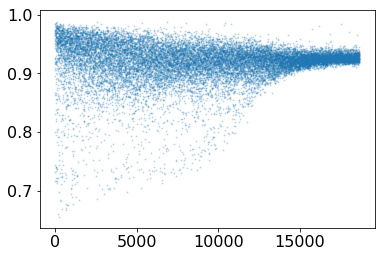

In [1192]:
from pyro_extras import get_log_prob_compl

with torch.no_grad():
    xi_posterior = fsd_model.get_sorted_fsd_xi(fsd_model.fsd_xi_posterior_loc_gq)
    zero = torch.tensor(0, device=device, dtype=dtype)
    fsd_params_dict = fsd_model.decode(xi_posterior)

    # get chimeric and real family size distributions
    fsd_lo_dist, fsd_hi_dist = fsd_model.get_fsd_components(fsd_params_dict)

    # extract required quantities from the distributions
    mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
    mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
    log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
    log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
    log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
    log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
    p_obs_lo_g = log_p_obs_lo_g.exp()
    p_obs_hi_g = log_p_obs_hi_g.exp()
    
plt.scatter(np.arange(sc_fingerprint_dtm.n_genes), p_obs_hi_g.cpu().numpy(), alpha=0.2, s=1)

## Visualizing the distributions parameters $\xi$

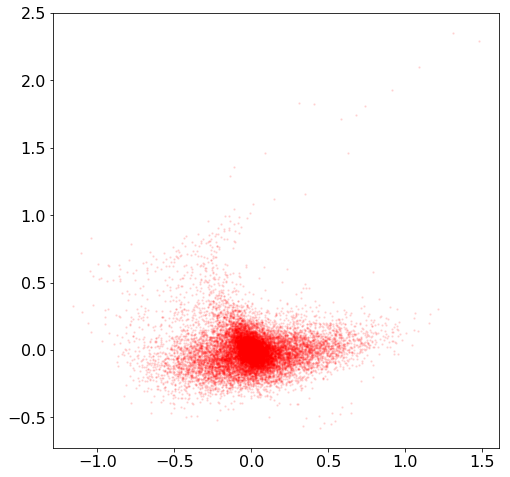

In [1193]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution
from sklearn.decomposition import PCA

n_prior_samples = 5_000

with torch.no_grad():
    xi_posterior = fsd_model.get_sorted_fsd_xi(fsd_model.fsd_xi_posterior_loc_gq).detach().cpu().numpy()
    
#     fsd_xi_prior_locs = fsd_model.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq"))
#     fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales_kq")
#     fsd_xi_prior_dist = model._get_fsd_xi_prior_dist(fsd_xi_prior_locs, fsd_xi_prior_scales)
#     xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()
    

pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_posterior)
# xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
# xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs_kq").detach().cpu().numpy())


fig = plt.figure(figsize=(8, 8))
# plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.5, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.1, s=2, color='red')
# for j in range(model.fsd_gmm_num_components):
#     plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
#     plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
# plt.legend()


In [1194]:
fsd_model.fsd_latent_posterior_loc_gl

Parameter containing:
tensor([[-0.0122,  2.7826],
        [ 0.0339, -0.3904],
        [-0.0080,  2.5812],
        ...,
        [ 0.2438, -0.1285],
        [ 0.1482, -0.0875],
        [-0.0219, -0.0740]], device='cuda:0', requires_grad=True)

In [1195]:
# n_steps = 20
# idx_0 = 1
# idx_1 = 0

# with torch.no_grad():
#     fsd_model.gplvm.set_mode("guide")
#     fsd_model.gplvm.set_data(X=fsd_model.fsd_latent_posterior_loc_gl.detach().clone(), y=None)
#     u = torch.zeros((n_steps, 2), device=device, dtype=dtype)
#     u[:, idx_0] = torch.linspace(-1, 1, steps=n_steps)
#     u[:, idx_1] = 0.
#     xi, _ = fsd_model.gplvm.forward(u)
#     fsd_params_dict = fsd_model.decode(xi.permute(-1, -2))

# dist_lo, dist_hi = fsd_model.get_fsd_components(fsd_params_dict)
# p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()
# p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()

# fig = plt.figure()
# for i in range(n_steps):
#     plt.plot(p_hi[i, :], alpha=0.1, color='black')

# fig = plt.figure()
# for i in range(n_steps):
#     plt.plot(p_lo[i, :], alpha=0.1, color='black')

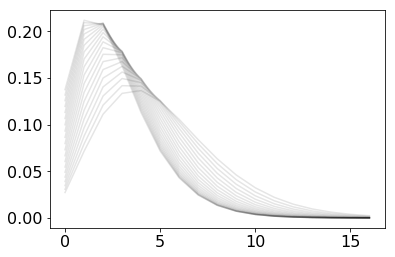

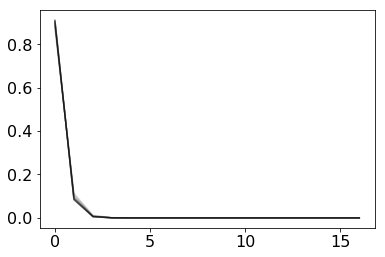

In [1198]:
n_steps = 20

idx_0 = 1
idx_1 = 0

with torch.no_grad():
    fsd_model.gplvm.set_mode("guide")
    fsd_model.gplvm.set_data(X=fsd_model.fsd_latent_posterior_loc_gl.detach().clone(), y=None)
    u = torch.zeros((n_steps, 2), device=device, dtype=dtype)
    u[:, idx_0] = torch.linspace(-10, 10, steps=n_steps)
    u[:, idx_1] = 0
    xi, _ = fsd_model.gplvm.forward(u)
    fsd_params_dict = fsd_model.decode(xi.permute(-1, -2))

dist_lo, dist_hi = fsd_model.get_fsd_components(fsd_params_dict)
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()

fig = plt.figure()
for i in range(n_steps):
    plt.plot(p_hi[i, :], alpha=0.1, color='black')

fig = plt.figure()
for i in range(n_steps):
    plt.plot(p_lo[i, :], alpha=0.1, color='black')

## Save Model

In [1199]:
model_output_path = os.path.join(
    output_path,
    f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().save(model_output_path)

## Extract and save gene expression posterior

In [1200]:
sampler = PosteriorGeneExpressionSampler(dtm, device, dtype)

run_mode = 'full'
only_expressing_cells = False

n_proposals_omega = 30
n_particles_omega = 10
n_particles_cell = 10
n_particles_expression = 20
log_frequency = 50

def get_init_cell_shard_size(gene_index):
    if gene_index < 200:
        return 50
    else:
        return 5000
    
suffix = ''
if run_mode == 'only_observed':
    suffix = 'only_observed'
elif run_mode == 'full':
    suffix = 'full'

In [ ]:
e_hi_map = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.int)
e_hi_mean = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)
e_hi_std = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)

t0 = time.time()

for i_gene in range(sc_fingerprint_dtm.n_genes):
#     expr_dict = sampler.get_gene_expression_posterior_moments_summary(
#         gene_index=i_gene,
#         n_particles_omega=n_particles_omega,
#         n_particles_cell=n_particles_cell,
#         cell_shard_size=cell_shard_size,
#         run_mode=run_mode,
#         only_expressing_cells=only_expressing_cells)
    
    adaptive_cell_shard_size = get_init_cell_shard_size(i_gene)
    expr_dict = None
    
    while True:
        try:
            expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
                gene_index=i_gene,
                n_proposals_omega=n_proposals_omega,
                n_particles_omega=n_particles_omega,
                n_particles_cell=n_particles_cell,
                n_particles_expression=n_particles_expression,
                cell_shard_size=adaptive_cell_shard_size,
                run_mode=run_mode,
                only_expressing_cells=only_expressing_cells)
        except (RuntimeError, ValueError) as e:
            print(e)
            logging.warning("CUDA out of memory -- reducing cell shard size and retrying...")
            adaptive_cell_shard_size = int(np.ceil(adaptive_cell_shard_size / 2))
        
        if expr_dict is not None:
            break
            
        if adaptive_cell_shard_size == 1:
            raise RuntimeError("Buy a better GPU!")

    e_hi_map[:, i_gene] = expr_dict['e_hi_map']
    e_hi_mean[:, i_gene] = expr_dict['e_hi_mean']
    e_hi_std[:, i_gene] = expr_dict['e_hi_std']
    
    if i_gene % log_frequency == 0 and i_gene > 0:
        t1 = time.time()
        seconds_per_gene = (t1 - t0) / log_frequency
        t0 = t1
        logging.warning(f'Processing gene {i_gene+1}/{sc_fingerprint_dtm.n_genes} ({seconds_per_gene:.2f} s/gene)...')

# gene indices and cell barcodes
original_gene_indices = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.gene_idx_list)
cell_barcodes = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.barcode_list)

# save
np.save(os.path.join(output_path, f'e_hi_map__{suffix}.npy'), e_hi_map)
np.save(os.path.join(output_path, f'e_hi_mean__{suffix}.npy'), e_hi_mean)
np.save(os.path.join(output_path, f'e_hi_std__{suffix}.npy'), e_hi_std)
np.save(os.path.join(output_path, 'gene_indices.npy'), original_gene_indices)
np.save(os.path.join(output_path, 'cell_barcodes.npy'), cell_barcodes)

In [51]:
# single_gene_data = sampler._generate_single_gene_minibatch_data(
#     gene_index=18848,
#     cell_index_list=np.random.randint(
#         low=0, high=sc_fingerprint_dtm.n_cells, size=n_fsd_posterior_samples),
#     n_particles_cell=1)
# ctx = sampler._get_trained_model_context(single_gene_data)
# np.where(np.sum(e_hi_map, axis=0) == 0)

# out2 = sampler.get_gene_expression_posterior_sampling_summary(
#     gene_index=18848,
#     n_proposals_omega=100,
#     n_particles_omega=50,
#     n_particles_cell=50,
#     n_particles_expression=50,
#     cell_shard_size=100,
#     run_mode=run_mode,
#     only_expressing_cells=True)

# out = sampler.get_gene_expression_posterior_moments_summary(
#     18848, 10, 10, 100, False, 'full')

In [ ]:
from pyro_extras import get_log_prob_compl

n_fsd_posterior_samples = 1000

zero = torch.tensor(0, device=device, dtype=dtype)
p_obs_lo_mean_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_hi_mean_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_lo_std_array = np.zeros((sc_fingerprint_dtm.n_genes,))
p_obs_hi_std_array = np.zeros((sc_fingerprint_dtm.n_genes,))

with torch.no_grad():
    for gene_index in range(sc_fingerprint_dtm.n_genes):
        single_gene_data = sc_fingerprint_dtm.generate_single_gene_fingerprint_minibatch_data(
            gene_index=gene_index,
            cell_index_list=np.random.randint(
                low=0, high=sc_fingerprint_dtm.n_cells, size=n_fsd_posterior_samples),
            n_particles_cell=1)
        guide_trace = poutine.trace(model.guide).get_trace(single_gene_data)
        fsd_params_dict = guide_trace.nodes['_RETURN']['value']['fsd_params_dict']

        # get chimeric and real family size distributions
        fsd_lo_dist, fsd_hi_dist = fsd_model.get_fsd_components(fsd_params_dict)

        # extract required quantities from the distributions
        mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
        mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
        
        log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
        log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
        
        log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
        log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
        
        p_obs_lo_g = log_p_obs_lo_g.exp()
        p_obs_hi_g = log_p_obs_hi_g.exp()
        
        p_obs_lo_mean_array[gene_index] = torch.mean(p_obs_lo_g)
        p_obs_hi_mean_array[gene_index] = torch.mean(p_obs_hi_g)

        p_obs_lo_std_array[gene_index] = torch.std(p_obs_lo_g)
        p_obs_hi_std_array[gene_index] = torch.std(p_obs_hi_g)

np.save(os.path.join(output_path, 'p_obs_lo_mean.npy'), p_obs_lo_mean_array)
np.save(os.path.join(output_path, 'p_obs_hi_mean.npy'), p_obs_hi_mean_array)
np.save(os.path.join(output_path, 'p_obs_lo_std.npy'), p_obs_lo_std_array)
np.save(os.path.join(output_path, 'p_obs_hi_std.npy'), p_obs_hi_std_array)

In [ ]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [ ]:
# use_other = True
# other_model_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/pbmc4k_19822_genes_marginalized.pyro'
# other_genes_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/gene_indices.npy'
# kappa = 1.0

# if use_other:
#     with torch.no_grad():
#         other_gene_idx_list = np.load(other_genes_path)
#         other_gene_id_to_gene_idx_map = {gene_id: gene_idx for gene_idx, gene_id in enumerate(other_gene_idx_list)}
#         gene_slice = [other_gene_id_to_gene_idx_map[gene_id] for gene_id in sc_fingerprint_base.gene_idx_list]

#         other_state_dict = torch.load(other_model_path)
#         adapted_state_dict = dict()

#         adapted_state_dict['constraints'] = other_state_dict['constraints']
#         adapted_state_dict['params'] = dict()

#         # independent of sampling rate
#         adapted_state_dict['params']['e_hi_zeta_loc_r'] = other_state_dict['params']['e_hi_zeta_loc_r']
#         adapted_state_dict['params']['e_hi_zeta_scale_tril_rr'] = other_state_dict['params']['e_hi_zeta_scale_tril_rr']
#         adapted_state_dict['params']['e_hi_zeta_posterior_loc_gr'] = other_state_dict['params']['e_hi_zeta_posterior_loc_gr'][gene_slice, :]
#         adapted_state_dict['params']['e_hi_zeta_posterior_scale_gr'] = other_state_dict['params']['e_hi_zeta_posterior_scale_gr'][gene_slice, :]
#         # adapted_state_dict['params']['alpha_c'] = init_params_dict['chimera.alpha_c']
#         # adapted_state_dict['params']['beta_c'] = init_params_dict['chimera.beta_c']

#         # don't know how to transform, so let's directly bring over
#         adapted_state_dict['params']['fsd_xi_prior_scales_kq'] = other_state_dict['params']['fsd_xi_prior_scales_kq']
#         adapted_state_dict['params']['fsd_xi_posterior_scale_gq'] = other_state_dict['params']['fsd_xi_posterior_scale_gq'][gene_slice, :]

#         # need to be downsampled property
#         fsd_prior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_prior_locs_kq'])
#         downsampled_fsd_prior_params_dict = dict()
#         downsampled_fsd_prior_params_dict['phi_lo'] = fsd_prior_params_dict['phi_lo']
#         downsampled_fsd_prior_params_dict['phi_hi'] = fsd_prior_params_dict['phi_hi']
#         downsampled_fsd_prior_params_dict['w_lo'] = fsd_prior_params_dict['w_lo']
#         downsampled_fsd_prior_params_dict['w_hi'] = fsd_prior_params_dict['w_hi']
#         downsampled_fsd_prior_params_dict['mu_lo'] = kappa * fsd_prior_params_dict['mu_lo']
#         downsampled_fsd_prior_params_dict['mu_hi'] = kappa * fsd_prior_params_dict['mu_hi']
#         downsampled_fsd_xi_prior_locs_kq = fsd_codec.encode(downsampled_fsd_prior_params_dict)
#         adapted_state_dict['params']['fsd_xi_prior_locs_kq'] = downsampled_fsd_xi_prior_locs_kq

#         fsd_posterior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_posterior_loc_gq'][gene_slice, :])
#         downsampled_fsd_posterior_params_dict = dict()
#         downsampled_fsd_posterior_params_dict['phi_lo'] = fsd_posterior_params_dict['phi_lo']
#         downsampled_fsd_posterior_params_dict['phi_hi'] = fsd_posterior_params_dict['phi_hi']
#         downsampled_fsd_posterior_params_dict['w_lo'] = fsd_posterior_params_dict['w_lo']
#         downsampled_fsd_posterior_params_dict['w_hi'] = fsd_posterior_params_dict['w_hi']
#         downsampled_fsd_posterior_params_dict['mu_lo'] = kappa * fsd_posterior_params_dict['mu_lo']
#         downsampled_fsd_posterior_params_dict['mu_hi'] = kappa * fsd_posterior_params_dict['mu_hi']
#         downsampled_fsd_xi_posterior_loc_gq = fsd_codec.encode(downsampled_fsd_posterior_params_dict)
#         adapted_state_dict['params']['fsd_xi_posterior_loc_gq'] = downsampled_fsd_xi_posterior_loc_gq    

#     for name, param in adapted_state_dict['params'].items():
#         adapted_state_dict['params'][name] = torch.autograd.Variable(param.data, requires_grad=True)
    
#     pyro.get_param_store().set_state(adapted_state_dict)

#     ##################
#     # model.mean_total_reads_per_cell = np.median(sc_fingerprint_dtm.total_obs_reads_per_cell).item()
#     # model.mean_fsd_mu_hi = np.median(sc_fingerprint_dtm.empirical_fsd_mu_hi).item()
#     ##################
    
# else:
    
#     model_output_path = os.path.join(
#         other_output_path,
#         f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
#     pyro.get_param_store().load(model_output_path)

In [ ]:
# sc_fingerprint_base_small = sc_fingerprint_base.subset_genes(np.asarray(sc_fingerprint_base.gene_idx_list)[:300])
# sc_fingerprint_dtm_small = SingleCellFingerprintDTM(sc_fingerprint_base_small, allow_dense_int_ndarray=True)

# fig = plt.figure(figsize=(4, 4))
# ax = plt.gca()
# ax.imshow(np.log1p(sc_fingerprint_dtm_small.dense_fingerprint_ndarray.sum(-1)[::16, :]).T, vmin=0, vmax=2, cmap=plt.cm.gray_r, origin='lower')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.tight_layout()
# plt.savefig(f'plot_count_matrix.png', dpi=100, transparent=True)

# fig = plt.figure(figsize=(4, 4))
# ax = plt.gca()
# for fs in range(0, 30):
#     ax.imshow(np.log1p(sc_fingerprint_dtm_small.dense_fingerprint_ndarray[::16, :, fs]).T, vmin=0, vmax=2, cmap=plt.cm.gray_r, origin='lower')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.tight_layout()
#     plt.savefig(f'plot_fs_{fs}.png', dpi=100, transparent=True)

## Playground

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
feature_gene_indices = hvg_selector.get_highly_variable_gene_indices()
raw_count_matrix = np.asarray(sc_fingerprint_dtm.sparse_family_size_truncated_count_matrix_csc[:, feature_gene_indices].todense())

# normalize by total counts
normed_count_matrix = raw_count_matrix / sc_fingerprint_dtm.total_obs_molecules_per_cell[:, None]

# log transform
mean_obs_molecules_per_cell = np.mean(sc_fingerprint_dtm.total_obs_molecules_per_cell)
trans_count_matrix = np.log1p(mean_obs_molecules_per_cell * normed_count_matrix)

In [ ]:
pca = PCA(n_components=20, whiten=True)
out_pca = pca.fit_transform(trans_count_matrix)

In [ ]:
plt.scatter(out_pca[:, 0], out_pca[:, 1], s=1, alpha=0.5)

In [ ]:
out_pca.shape

In [ ]:
np.concatenate((out_pca, sc_fingerprint_dtm.total_obs_molecules_per_cell[:, None]), axis=1).shape

In [ ]:
## binarized family-size truncated count matrix

In [ ]:
self = sc_fingerprint_dtm

dense_fst_count_matrix = self.dense_family_size_truncated_count_matrix_ndarray
normed_fst_count_matrix = dense_fst_count_matrix / self.empirical_droplet_efficiency[:, None]
median_normed_expr_per_gene = np.median(normed_fst_count_matrix, axis=0)
median_based_hard_expression_mask = normed_fst_count_matrix > median_normed_expr_per_gene[None, :]


expr_family_size_truncated_count_matrix = np.log1p(normed_fst_count_matrix * hard_expression_mask)

In [ ]:
# perform PCA
pca_features = PCA(n_components=self.n_cell_pca_features, whiten=True).fit_transform(
    expr_family_size_truncated_count_matrix[:, self.highly_variable_gene_indices])

In [ ]:
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5, s=1)

In [ ]:
plt.scatter(self.features_per_cell[:, 0], self.features_per_cell[:, 1], alpha=0.5, s=1)

In [ ]:
gene_index = 101
r = np.sum(sc_fingerprint_dtm.dense_count_matrix_ndarray[human_droplets, gene_index]) / (
    len(human_droplets) * 0.5)
c = np.sum(sc_fingerprint_dtm.dense_count_matrix_ndarray[mouse_droplets, gene_index]) / (
    len(mouse_droplets) * 0.15)

print(sc_fingerprint_dtm.empirical_fsd_mu_hi[gene_index])

In [ ]:
np.mean(sc_fingerprint_dtm.dense_count_matrix_ndarray[mouse_droplets, gene_index])

In [ ]:
c / r

In [ ]:
z = torch.distributions.Exponential(rate=10.0).sample([100000])

In [ ]:
plt.hist(z.log().numpy(), bins=50);